<a href="https://colab.research.google.com/github/Niveditathakur/Regression/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns

from sklearn import model_selection, preprocessing, decomposition
from sklearn.utils import shuffle
from matplotlib.patches import Ellipse

from sklearn.preprocessing import LabelEncoder,  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from keras.utils import np_utils
# Use scikit-learn to grid search the batch size and epochs
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

seed = 7
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))


from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, BatchNormalization, MaxPooling1D, Activation, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings("ignore")


In [0]:
# load dataset
from sklearn.datasets import load_boston
boston_data = load_boston()

print('Boston Data Input Shape:', boston_data.data.shape)
print('Boston Data Target Shape:', boston_data.target.shape)
print('Boston Data Feature Names:', boston_data.feature_names)

# Following line will print the detailed description of the data
#print('Feature Description:', boston_dataset.DESCR)

In [0]:
# convert the input boston data feature into a pandas dataframe with columns as features
#print( boston.head(3) )
boston = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
print( boston.head(3) )

#plot histogram of input featues to see if feature scaling is required
boston.hist()
plt.show()

#we can check if there is a null value - this dataset has none
#boston.isnull().sum()

In [0]:
#can use density plots as well
boston.plot(kind='density', subplots=True, layout = (5,3),   sharex=False)
plt.show()
# some of them are univariate while a few are bi-variate

In [0]:
# add the target (ouput) price to the pandas dataframe as well 
boston['Price'] = boston_data.target
print( boston.head(3) )

# plot the distributio on output (target) values only
sns.distplot(boston['Price'], bins=30)
plt.show()

In [0]:
#Check the correlation in the input features and with the output target
correlation_matrix = boston.corr()
sns.heatmap(data=correlation_matrix,  cmap='coolwarm')

# Price is strongly correlated with RM, could be an important feature for our task 
# RAD, TAX have high correlation and one of them could be dropped

In [0]:
# Helper functions for the regression problem 

num_folds = 3 
err_range = 5 # Error range to find percentage of correctly predictied house price in multiples of $1000

reg_models = [linear_model.LinearRegression(), 
              linear_model.BayesianRidge(),
              linear_model.Ridge(alpha=.5), 
              linear_model.Lasso(alpha=0.1), 
              linear_model.LassoLars(alpha=.1), 
              SVR(kernel='rbf', C=1e3, gamma=0.1)]


def Fxn_RG(TrainInput1, TrainOutput1, scaling=1): 
    
    if scaling ==1: 
        x_scaled = min_max_scaler.fit_transform(TrainInput1) 
        TrainInput1.loc[:,:] = x_scaled
        
    TrainInput1 = TrainInput1.values
    
    log_cols=["Model","RMSE", "RMSE-Std", "Fold-RMSE", "Fold-RMSE-Std", "ErrorRange","ErrorRange-Std"] 
    log = pd.DataFrame(columns=log_cols)
        
    #KFolds
    kfold = model_selection.KFold(n_splits=num_folds, shuffle=True)
     
    for reg in reg_models:
        name     = reg.__class__.__name__
        
        #scoring is negative mean squared error it is regression task
        scores  = model_selection.cross_val_score(reg,  TrainInput1, TrainOutput1, cv=kfold, 
                                                  scoring="neg_mean_squared_error") 
        rmse_scores = np.sqrt(-scores)
        
        # Manual three fold validataion
        RMSEList  = list()
        ErrorList = list()
        
        
        for train_index, test_index in kfold.split(TrainInput1):

            X_train, X_test    = TrainInput1[ train_index, :], TrainInput1[test_index,:]
            y_train, y_test    = TrainOutput1[train_index], TrainOutput1[test_index]
            reg.fit(X_train,  y_train)
            
            # Make predictions using the testing set
            y_pred             = reg.predict(X_test)
            err_rmse           = rmse(y_pred, y_test)
            RMSEList.append(err_rmse)
                        
            #plot the predicted and true house prices
            Plot_Fx(np.array(y_test), np.array(y_pred))
            
            Error         = 1 - ( ( np.shape( np.where( (y_pred - y_test) > err_range ) )[1] +
                                np.shape( np.where( (y_pred - y_test) < -err_range ) )[1] ) / y_pred.shape[0] ) 
            ErrorList.append(Error)
        
        print('Original vs Predicted Plot for', name)
        plt.show() 
        
        RMSEList  = np.array(RMSEList)
        ErrorList = np.array(ErrorList)
                    
        log_entry  =  pd.DataFrame([[name, rmse_scores.mean(), rmse_scores.std(), 
                                     RMSEList.mean(),  RMSEList.std(), 
                                     ErrorList.mean()*100, ErrorList.std()*100 ]], columns=log_cols)        
        log        =  log.append(log_entry)
        

    return(log)

def Plot_Fx(y_test, y_pred):
    plt.scatter(list(range(y_pred.shape[0])), y_test, marker='x', c='black')
    plt.scatter(list(range(y_pred.shape[0])), y_pred, marker='o', c='g')
    plt.title('Original - Black (x), Predicted - green (o)')
    plt.grid(True)
    
    

def rmse(preds, targets):
    return np.sqrt(((preds - targets) ** 2).mean())        


Original vs Predicted Plot for LinearRegression


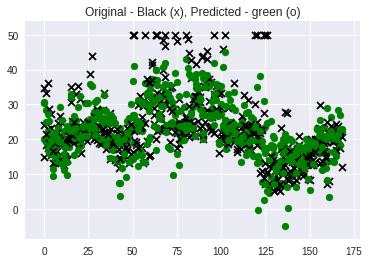

Original vs Predicted Plot for BayesianRidge


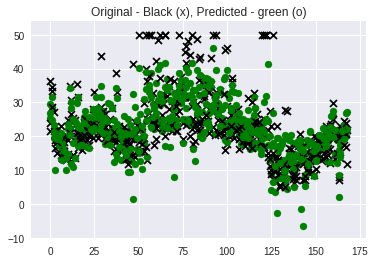

Original vs Predicted Plot for Ridge


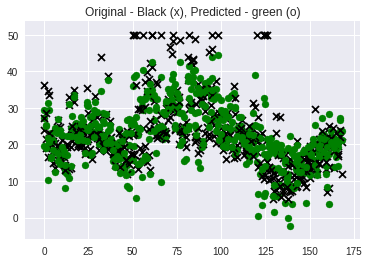

Original vs Predicted Plot for Lasso


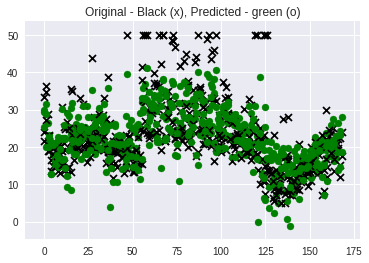

Original vs Predicted Plot for LassoLars


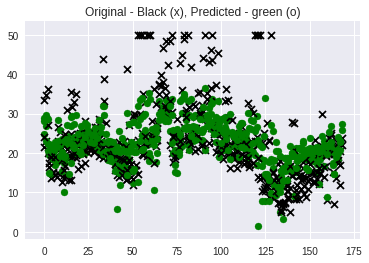

Original vs Predicted Plot for SVR


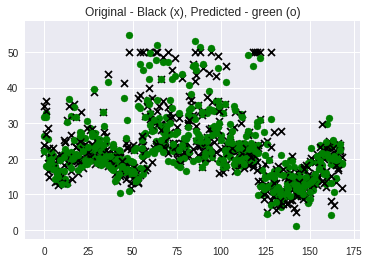

              Model      RMSE  RMSE-Std  Fold-RMSE  Fold-RMSE-Std  ErrorRange  \
0  LinearRegression  4.961808  0.216987   4.883908       0.369135   77.073354   
0     BayesianRidge  4.793172  0.287363   4.959516       0.268068   79.248849   
0             Ridge  4.950412  0.172040   5.132966       0.390403   76.285573   
0             Lasso  5.053385  0.142867   5.087865       0.486204   79.048089   
0         LassoLars  5.738208  0.135746   5.755151       0.146252   73.709730   
0               SVR  3.292363  0.759682   3.290840       0.579023   92.885320   

   ErrorRange-Std  
0        1.578133  
0        1.933410  
0        2.202679  
0        2.687961  
0        2.251778  
0        0.966474  


In [0]:
#derive data and labels
data   = boston.drop('Price', axis = 1)  
labels = boston['Price']

log    = Fxn_RG(data, labels, scaling = 1)
print(log)

In [0]:
# Owing to its best performance we will use SVR 
reg = SVR(kernel='rbf', C=1e3, gamma=0.1)

x_scaled      = min_max_scaler.fit_transform(data) 
data.loc[:,:] = x_scaled
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.3, random_state=seed)

X_train      =    X_train.values
X_test       =    X_test.values
y_train      =    y_train.values
y_test       =    y_test.values
# Train the model using the training sets
reg.fit(X_train,  y_train)

# Make predictions using the training set
y_predT = reg.predict(X_train)
# Make predictions using the testing set
y_pred  = reg.predict(X_test)

# The mean squared error
print("Train Root Mean squared error: %.2f" %np.sqrt(mean_squared_error( y_train,  y_predT)))
print("Test Root Mean squared error: %.2f" %np.sqrt(mean_squared_error( y_test,  y_pred)))
print('Variance score: %.2f' % r2_score( y_test,  y_pred))


In [0]:
# Use PCA to reduce the dimensionality
pca = decomposition.PCA(n_components=2)
fit = pca.fit(data.values)
# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_ )

print('Data shape (before PCA)', data.shape)
data_PCA = fit.transform(data.values)

print('Data shape after PCA', data_PCA.shape)

In [0]:
# Performance of the SVR regression with 5 PCA components
X_train, X_test, y_train, y_test = train_test_split(data_PCA, labels, test_size=.3, random_state=seed)

# Train the model using the training sets
reg.fit(X_train,  y_train)

# Make predictions using the training set
y_predT = reg.predict(X_train)
# Make predictions using the testing set
y_pred  = reg.predict(X_test)

# The mean squared error
print("Train Root Mean squared error: %.2f" %np.sqrt(mean_squared_error( y_train,  y_predT)))
print("Test Root Mean squared error: %.2f" %np.sqrt(mean_squared_error( y_test,  y_pred)))
print('Variance score: %.2f' % r2_score( y_test,  y_pred))

# with only 2 PC we perfrom okay as compared to all the 13 features

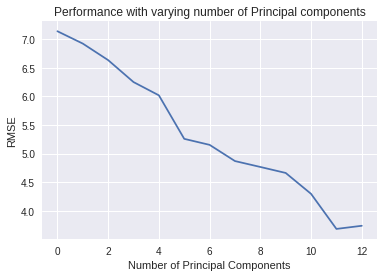

In [0]:
# Let us see the performance with varyig number of principal components 

reg_res = list() # empty list to store results

for i in range(data.shape[1]):
  pca = sklearn.decomposition.PCA(n_components=i+1)
  fit = pca.fit(data.values)
  data_PCA = fit.transform(data.values)
  #Train - test split
  X_train, X_test, y_train, y_test = train_test_split(data_PCA, labels, test_size=.3, random_state=seed)

  # Train the model using the training sets
  reg.fit(X_train,  y_train)

  # Make predictions using the testing set
  y_pred  = reg.predict(X_test)
  
  #append the RMSE to the list
  reg_res.append(np.sqrt(mean_squared_error( y_test,  y_pred)))
  
plt.plot(reg_res)
plt.title('Performance with varying number of Principal components')
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.grid(True) 